# Procesamiento de lenguaje natural
## Desafío 3
### Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [3]:
import random
import io
import pickle

import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.python.client import device_lib
import tensorflow as tf
import tensorflow.keras.backend as K

2024-06-30 00:31:18.225996: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 00:31:18.236279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 00:31:18.250478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 00:31:18.250506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 00:31:18.260415: I tensorflow/core/platform/cpu_feature_gua

### Datos
Se utiliza como dataset textos del libro *The Happy Prince and Other Tales* disponible en Project Gutenberg: [The Happy Prince and Other Tales](https://www.gutenberg.org/cache/epub/902/pg902.txt)


In [7]:
file_path = os.path.join("docs", "the_happy_prince_and_other_tales")

with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

print(text[:1000])

The Project Gutenberg eBook of The Happy Prince, and Other Tales
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Happy Prince, and Other Tales

Author: Oscar Wilde

Release date: May 1, 1997 [eBook #902]
                Most recently updated: October 25, 2021

Language: English

Credits: David Price and Paul Redmond


*** START OF THE PROJECT GUTENBERG EBOOK THE HAPPY PRINCE, AND OTHER TALES ***

                          [Picture: Book cover]

                       [Picture: The Happy Prince]





                             The Happy Prince
                             And Othe

In [8]:
def remove_previous_text(text, intro_marker):
    """ remove introduction """
    intro_index = text.find(intro_marker)
    if intro_index !=-1:
        return text[intro_index + len(intro_marker):].strip()
    return text

In [9]:
def remove_text_below(text, end_marker):
    """remove text at the end"""
    end_marker_pos = text.find(end_marker)
    if end_marker_pos != -1:
        return text[:end_marker_pos]
    return text

In [10]:
def remove_lineas_picture(texto):
    patron = r'^\[Picture:.*\]$'
    lineas = texto.splitlines()
    lineas_filtradas = [linea for linea in lineas if not re.match(patron, linea.strip())]
    texto_sin_pictures = '\n'.join(lineas_filtradas)    
    return texto_sin_pictures

In [11]:
def remove_empty_lines(text):
    lines = text.split('\n')
    clean_lines = [line for line in lines if line.strip()]
    clean_text = '\n'.join(clean_lines)
    return clean_text

In [12]:
def remove_end_lines(text):
    cleaned_text = text.replace("\n", " ")
    return cleaned_text

In [13]:
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

intro_marker = "The Remarkable Rocket                     87"
end_marker = "* * * * *"


cleaned_text = remove_previous_text(text, intro_marker)
cleaned_text = remove_text_below(cleaned_text, end_marker)
cleaned_text = remove_lineas_picture(cleaned_text)
cleaned_text = remove_empty_lines(cleaned_text)
cleaned_text = remove_end_lines(cleaned_text)

output_file_path = os.path.join("docs", "cleaned_text.txt") 

with open(output_file_path, "w", encoding="utf-8") as output_file:
    output_file.write(cleaned_text)

print("Cleaned text saved to:", output_file_path)

Cleaned text saved to: docs/cleaned_text.txt


In [14]:
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [15]:
article_text = read_text_file(output_file_path)
article_text = article_text.lower()
article_text[:1000]

'the happy prince. high above the city, on a tall column, stood the statue of the happy prince.  he was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt. he was very much admired indeed.  “he is as beautiful as a weathercock,” remarked one of the town councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which he really was not. “why can’t you be like the happy prince?” asked a sensible mother of her little boy who was crying for the moon.  “the happy prince never dreams of crying for anything.” “i am glad there is some one in the world who is quite happy,” muttered a disappointed man as he gazed at the wonderful statue. “he looks just like an angel,” said the charity children as they came out of the cathedral in their bright scarlet cloaks and their clean white pinafores. “how do you know?” said the 

Para procesar el texto obtenido se utilizan varias funciones. Se eliminan los textos correspondientes al Proyecto Gutenberg, se eliminan los textos correspondientes a la presencia de fotografías, las líneas en blanco y, en este caso, los saltos de línea.

### Tamaño del contexto

In [16]:
max_context_size = 500

In [17]:
from tensorflow.keras.utils import pad_sequences

In [18]:
chars_vocab = set(article_text)

In [19]:
len(chars_vocab)

39

In [20]:
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [21]:
tokenized_text = [char2idx[ch] for ch in article_text]

In [22]:
tokenized_text[:1000]

[31,
 28,
 20,
 14,
 28,
 36,
 9,
 9,
 24,
 14,
 9,
 34,
 22,
 6,
 17,
 20,
 8,
 14,
 28,
 22,
 2,
 28,
 14,
 36,
 35,
 21,
 15,
 20,
 14,
 31,
 28,
 20,
 14,
 17,
 22,
 31,
 24,
 18,
 14,
 21,
 6,
 14,
 36,
 14,
 31,
 36,
 26,
 26,
 14,
 17,
 21,
 26,
 12,
 1,
 6,
 18,
 14,
 10,
 31,
 21,
 21,
 29,
 14,
 31,
 28,
 20,
 14,
 10,
 31,
 36,
 31,
 12,
 20,
 14,
 21,
 7,
 14,
 31,
 28,
 20,
 14,
 28,
 36,
 9,
 9,
 24,
 14,
 9,
 34,
 22,
 6,
 17,
 20,
 8,
 14,
 14,
 28,
 20,
 14,
 33,
 36,
 10,
 14,
 2,
 22,
 26,
 29,
 20,
 29,
 14,
 36,
 26,
 26,
 14,
 21,
 15,
 20,
 34,
 14,
 33,
 22,
 31,
 28,
 14,
 31,
 28,
 22,
 6,
 14,
 26,
 20,
 36,
 15,
 20,
 10,
 14,
 21,
 7,
 14,
 7,
 22,
 6,
 20,
 14,
 2,
 21,
 26,
 29,
 18,
 14,
 7,
 21,
 34,
 14,
 20,
 24,
 20,
 10,
 14,
 28,
 20,
 14,
 28,
 36,
 29,
 14,
 31,
 33,
 21,
 14,
 35,
 34,
 22,
 2,
 28,
 31,
 14,
 10,
 36,
 9,
 9,
 28,
 22,
 34,
 20,
 10,
 18,
 14,
 36,
 6,
 29,
 14,
 36,
 14,
 26,
 36,
 34,
 2,
 20,
 14,
 34,
 20,
 29,
 14,
 34,
 1

### Organizando y estructurando el dataset

In [23]:
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [24]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [25]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [26]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [27]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [28]:
X.shape

(76128, 500)

In [29]:
X[0,:10]

array([31, 28, 20, 14, 28, 36,  9,  9, 24, 14])

In [30]:
y[0,:10]

array([28, 20, 14, 28, 36,  9,  9, 24, 14,  9])

In [31]:
vocab_size = len(chars_vocab)

# Modelo SimpleRNN

In [5]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [28]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

2024-06-24 03:46:46.931450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-24 03:46:46.991570: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: no se puede abrir el archivo del objeto compartido: No existe el archivo o el directorio
2024-06-24 03:46:46.991601: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 39)         0         
 ibuted)                                                         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         48000     
                                                                 
 dense (Dense)               (None, None, 39)          7839      
                                                                 
Total params: 55,839
Trainable params: 55,839
Non-trainable params: 0
_________________________________________________________________



### Definir el modelo

Se utiliza un callback *ad-hoc* que la calcule la perplejidad en cada epoch.

In [34]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name="my_model", patience=5):
      
      self.val_data = val_data
      self.model_name = model_name

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      for seq in self.val_data:

        len_seq = len(seq)

        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        for start,end in self.info:

          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [30]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "SIMPLERNN_character")], batch_size=256)

Epoch 1/20
298/298 [==============================] - ETA: 0s - loss: 2.3899
 mean perplexity: 16.204191967264446 



INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


Saved new model!
298/298 [==============================] - 147s 493ms/step - loss: 2.3899
Epoch 2/20
298/298 [==============================] - ETA: 0s - loss: 2.0363
 mean perplexity: 14.291580729275982 



INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


Saved new model!
298/298 [==============================] - 146s 489ms/step - loss: 2.0363
Epoch 3/20
298/298 [==============================] - ETA: 0s - loss: 1.8853
 mean perplexity: 13.2281218722765 



INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


Saved new model!
298/298 [==============================] - 146s 490ms/step - loss: 1.8853
Epoch 4/20
298/298 [==============================] - ETA: 0s - loss: 1.7696
 mean perplexity: 11.346188663941923 



INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


Saved new model!
298/298 [==============================] - 146s 489ms/step - loss: 1.7696
Epoch 5/20
298/298 [==============================] - ETA: 0s - loss: 1.6887
 mean perplexity: 11.663174035402294 

298/298 [==============================] - 145s 486ms/step - loss: 1.6887
Epoch 6/20
298/298 [==============================] - ETA: 0s - loss: 1.6312
 mean perplexity: 11.031341567748774 



INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


Saved new model!
298/298 [==============================] - 146s 490ms/step - loss: 1.6312
Epoch 7/20
298/298 [==============================] - ETA: 0s - loss: 1.5892
 mean perplexity: 10.170827215472654 



INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


INFO:tensorflow:Assets written to: SIMPLERNN_character/assets


Saved new model!
298/298 [==============================] - 146s 489ms/step - loss: 1.5892
Epoch 8/20
298/298 [==============================] - ETA: 0s - loss: 1.5579
 mean perplexity: 11.144353074306824 

298/298 [==============================] - 143s 481ms/step - loss: 1.5579
Epoch 9/20
298/298 [==============================] - ETA: 0s - loss: 1.5339
 mean perplexity: 11.106779657259853 

298/298 [==============================] - 143s 481ms/step - loss: 1.5339
Epoch 10/20
298/298 [==============================] - ETA: 0s - loss: 1.5145
 mean perplexity: 11.371791076091606 

298/298 [==============================] - 143s 480ms/step - loss: 1.5145
Epoch 11/20
298/298 [==============================] - ETA: 0s - loss: 1.4989
 mean perplexity: 11.645626209752546 

298/298 [==============================] - 143s 481ms/step - loss: 1.4989
Epoch 12/20
298/298 [==============================] - ETA: 0s - loss: 1.4855
 mean perplexity: 11.457452736393723 

Stopping training...
298/298 [

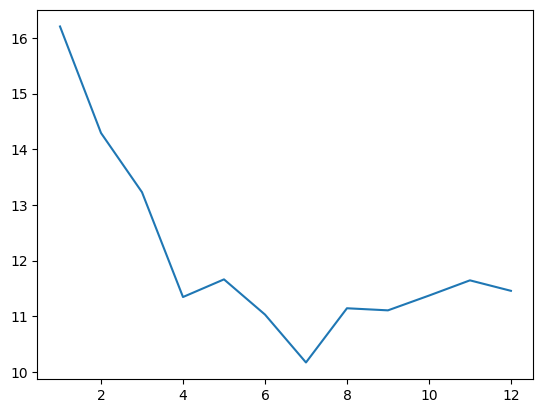

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [32]:
model = keras.models.load_model('SIMPLERNN_character')


### Predicción del próximo caracter

In [5]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


Algunas imagenes obtenidas de gradio:
![img1](images/char1simplernn.png)
![img2](images/char2simplernn.png)
![img3](images/char3simplernn.png)
![img5](images/char5simplernn.png)
![img6](images/char6simplernn.png)
![img7](images/char7simplernn.png)

### Generación de secuencias

In [40]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

        output_text += out_word
    return output_text

In [36]:
input_text='There was no doubt'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'There was no doubt of the story of the staruse t'

In [37]:
input_text="I could not get anything"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)


'I could not get anything and little hans, and the mill'

In [38]:
input_text="So the Nightingale flew"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'So the Nightingale flew over the miller, ‘i am going '

In [39]:
input_text="The Happy Prince"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'The Happy Prince, “i am going to the prince, “'

###  Beam search y muestreo aleatorio

In [45]:

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [46]:
from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    encoded = encode(input)

  
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        input_update = np.array([hist[i+1:]]).copy()

        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [46]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="the happy prince")

In [47]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [48]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    the happy prince, and the miller, ‘i'

In [51]:
salidas = beam_search(model,num_beams=10,num_words=20,input="i know it is very generous of me")

In [58]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [52]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    i know it is very generous of me, and the miller, ‘i'

In [53]:
salidas = beam_search(model,num_beams=10,num_words=20,input="many people would")

In [54]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [55]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   many people would not said the miller'

In [56]:
salidas = beam_search(model,num_beams=10,num_words=20,input="the storm grew")

In [57]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [58]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      the storm grew,” said the miller, '

# Modelo LSTM

In [62]:
# Definir el modelo
from tensorflow.keras.optimizers import RMSprop
model_lstm = Sequential()

# Añadir capas
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo con una learning rate específica
optimizer = RMSprop(learning_rate=0.0001)  # Aquí puedes ajustar la learning rate según lo necesites
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# Compilar el modelo
#model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

# Mostrar el resumen del modelo
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 39)         0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, None, 200)         192000    
                                                                 
 dense_3 (Dense)             (None, None, 39)          7839      
                                                                 
Total params: 199,839
Trainable params: 199,839
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

In [63]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "LSTM_character")], batch_size=256)

Epoch 1/20
298/298 [==============================] - ETA: 0s - loss: 3.0526
 mean perplexity: 23.95976147786768 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 331s 1s/step - loss: 3.0526
Epoch 2/20
298/298 [==============================] - ETA: 0s - loss: 2.8883
 mean perplexity: 23.505440167513097 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 339s 1s/step - loss: 2.8883
Epoch 3/20
298/298 [==============================] - ETA: 0s - loss: 2.8068
 mean perplexity: 23.350655886185173 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 338s 1s/step - loss: 2.8068
Epoch 4/20
298/298 [==============================] - ETA: 0s - loss: 2.6885
 mean perplexity: 21.60405849265745 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 323s 1s/step - loss: 2.6885
Epoch 5/20
298/298 [==============================] - ETA: 0s - loss: 2.5707
 mean perplexity: 21.012421839171502 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 323s 1s/step - loss: 2.5707
Epoch 6/20
298/298 [==============================] - ETA: 0s - loss: 2.4751
 mean perplexity: 20.162760722113987 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 348s 1s/step - loss: 2.4751
Epoch 7/20
298/298 [==============================] - ETA: 0s - loss: 2.4014
 mean perplexity: 18.969929359711045 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 367s 1s/step - loss: 2.4014
Epoch 8/20
298/298 [==============================] - ETA: 0s - loss: 2.3443
 mean perplexity: 18.19307243639287 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 380s 1s/step - loss: 2.3443
Epoch 9/20
298/298 [==============================] - ETA: 0s - loss: 2.2991
 mean perplexity: 17.965874468556823 



INFO:tensorflow:Assets written to: LSTM_character/assets


INFO:tensorflow:Assets written to: LSTM_character/assets


Saved new model!
298/298 [==============================] - 376s 1s/step - loss: 2.2991
Epoch 10/20
298/298 [==============================] - ETA: 0s - loss: 2.2616
 mean perplexity: 18.092246103896585 

298/298 [==============================] - 376s 1s/step - loss: 2.2616
Epoch 11/20
298/298 [==============================] - ETA: 0s - loss: 2.2293
 mean perplexity: 18.764935314692263 

298/298 [==============================] - 370s 1s/step - loss: 2.2293
Epoch 12/20
298/298 [==============================] - ETA: 0s - loss: 2.2012
 mean perplexity: 18.439672547576308 

298/298 [==============================] - 349s 1s/step - loss: 2.2012
Epoch 13/20
298/298 [==============================] - ETA: 0s - loss: 2.1761
 mean perplexity: 20.46309058778311 

298/298 [==============================] - 325s 1s/step - loss: 2.1761
Epoch 14/20
298/298 [==============================] - ETA: 0s - loss: 2.1532
 mean perplexity: 20.881947578235014 

Stopping training...
298/298 [==============

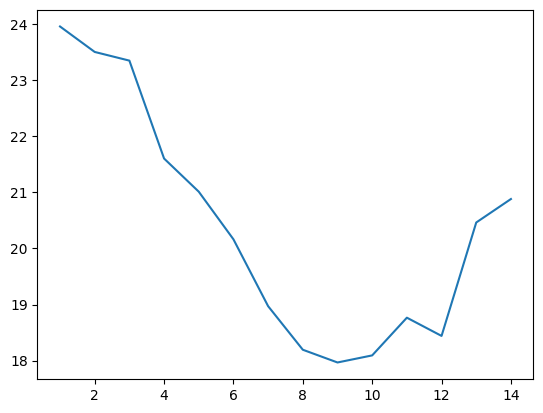

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [65]:
model = keras.models.load_model('LSTM_character')

### Predicción del próximo caracter

In [66]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 77ms/step
Keyboard interruption in main thread... closing server.


Algunas imagenes obtenidas de gradio:
![img1](images/char1lsm.png)
![img2](images/char2lsm.png)
![img3](images/char3lsm.png)
![img5](images/char5lsm.png)
![img6](images/char6lsm.png)
![img7](images/char7lsm.png)

### Generación de secuencias

In [68]:
input_text='There was no doubt'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'There was no doubt the the the the the the the t'

In [69]:
input_text="I could not get anything"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'I could not get anything and the the the the the the t'

In [70]:
input_text="So the Nightingale flew"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'So the Nightingale flewer and the the the the the the'

In [71]:
input_text="The Happy Prince"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'The Happy Prince the the the the the the the t'

### Beam search y muestreo aleatorio

In [72]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="the happy prince")

In [73]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [74]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    the happy prince, and the the the th'

In [75]:
salidas = beam_search(model,num_beams=10,num_words=20,input="i know it is very generous of me")

In [82]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [83]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      the storm grewand the the the the '

In [84]:
salidas = beam_search(model,num_beams=10,num_words=20,input="many people would")

In [85]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [86]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   many people would the the the the the'

In [87]:
salidas = beam_search(model,num_beams=10,num_words=20,input="the storm grew")

In [88]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [89]:
decode(salidas[0])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      the storm grewand the the the the '

### Modelo GRU

In [56]:
from tensorflow.keras.layers import TimeDistributed, Dense, GRU
# Definir el modelo
from tensorflow.keras.optimizers import RMSprop
model_gru = Sequential()

# Añadir capas
model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo con una learning rate específica
optimizer = RMSprop(learning_rate=0.0001)  # Aquí puedes ajustar la learning rate según lo necesites
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# Compilar el modelo
#model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

# Mostrar el resumen del modelo
model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 39)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       144,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 39)       │         7,839 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,439 (595.46 KB)

 Trainable params: 152,439 (595.46 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
history_ppl = []
hist = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "GRU_character")], batch_size=256)

Epoch 1/20
298/298 [==============================] - ETA: 0s - loss: 3.1356
 mean perplexity: 23.98707094565646 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 271s 905ms/step - loss: 3.1356
Epoch 2/20
298/298 [==============================] - ETA: 0s - loss: 2.8138
 mean perplexity: 21.63792260566212 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 268s 899ms/step - loss: 2.8138
Epoch 3/20
298/298 [==============================] - ETA: 0s - loss: 2.6263
 mean perplexity: 20.228730800450236 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 268s 898ms/step - loss: 2.6263
Epoch 4/20
298/298 [==============================] - ETA: 0s - loss: 2.4645
 mean perplexity: 21.321218212657246 

298/298 [==============================] - 266s 894ms/step - loss: 2.4645
Epoch 5/20
298/298 [==============================] - ETA: 0s - loss: 2.3660
 mean perplexity: 21.262796730669187 

298/298 [==============================] - 263s 881ms/step - loss: 2.3660
Epoch 6/20
298/298 [==============================] - ETA: 0s - loss: 2.3001
 mean perplexity: 19.576986806753347 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 266s 892ms/step - loss: 2.3001
Epoch 7/20
298/298 [==============================] - ETA: 0s - loss: 2.2511
 mean perplexity: 18.359169139859077 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 265s 890ms/step - loss: 2.2511
Epoch 8/20
298/298 [==============================] - ETA: 0s - loss: 2.2116
 mean perplexity: 17.121995840982486 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 265s 889ms/step - loss: 2.2116
Epoch 9/20
298/298 [==============================] - ETA: 0s - loss: 2.1782
 mean perplexity: 16.855929744779832 



INFO:tensorflow:Assets written to: GRU_character/assets


INFO:tensorflow:Assets written to: GRU_character/assets


Saved new model!
298/298 [==============================] - 264s 887ms/step - loss: 2.1782
Epoch 10/20
298/298 [==============================] - ETA: 0s - loss: 2.1487
 mean perplexity: 16.866288194788943 

298/298 [==============================] - 264s 887ms/step - loss: 2.1487
Epoch 11/20
298/298 [==============================] - ETA: 0s - loss: 2.1210
 mean perplexity: 17.183966618980556 

298/298 [==============================] - 264s 885ms/step - loss: 2.1210
Epoch 12/20
298/298 [==============================] - ETA: 0s - loss: 2.0945
 mean perplexity: 17.7465771433589 

298/298 [==============================] - 263s 884ms/step - loss: 2.0945
Epoch 13/20
298/298 [==============================] - ETA: 0s - loss: 2.0688
 mean perplexity: 18.14092380361529 

298/298 [==============================] - 263s 883ms/step - loss: 2.0688
Epoch 14/20
298/298 [==============================] - ETA: 0s - loss: 2.0431
 mean perplexity: 18.736260468738024 

Stopping training...
298/298 [=

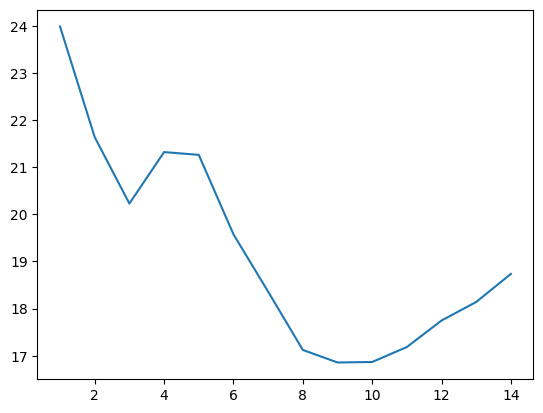

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [41]:
model = keras.models.load_model('GRU_character')

### Predicción del próximo caracter

In [42]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 405ms/step
Keyboard interruption in main thread... closing server.


Algunas imagenes obtenidas de gradio:
![img1](images/char1gru.png)
![img2](images/char2gru.png)
![img3](images/char3gru.png)
![img4](images/char4gru.png)
![img5](images/char5gru.png)
![img6](images/char6gru.png)

### Generación de secuencias

In [45]:
input_text='There was no doubt'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'There was no doubtmlznrme!mrwbmlznrmrwbmlznrmrwb'

In [46]:
input_text="I could not get anything"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'I could not get anythingmrwbmlznrmrwbmlznrmrwbmlznrmrw'

In [47]:
input_text="So the Nightingale flew"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'So the Nightingale flewbmlznrmrwbmlznrmrwbmlznrmrwbml'

In [48]:
input_text="The Happy Prince"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'The Happy Prince!amrwbmlznrmrwbmlznrmrwbmlznrm'

### Beam search y muestreo aleatorio

In [51]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="the happy prince")

In [52]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [53]:
decode(salidas[0])

'mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmthe happy prince!mrwbmrwbml-!imrwbml'

In [54]:
salidas = beam_search(model,num_beams=10,num_words=20,input="i know it is very generous of me")

In [55]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [56]:
decode(salidas[0])

'mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmi know it is very generous of me!mrwbml-!imrwbmrwbml'

In [57]:
salidas = beam_search(model,num_beams=10,num_words=20,input="many people would")

In [58]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [59]:
decode(salidas[0])

'mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmany people would:m-!imrwbm”-uumrwbml'

In [60]:
salidas = beam_search(model,num_beams=10,num_words=20,input="the storm grew")

In [61]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [62]:
decode(salidas[0])

'mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmthe storm grewbm”-uimrwbm”-uumrwbm'

### MODELO LSTM con lr = 0.001

In [32]:
model_lstm2 = Sequential()

model_lstm2.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm2.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm2.add(Dense(vocab_size, activation='softmax'))
model_lstm2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm2.summary()

/home/cristina/.local/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-06-30 00:32:42.632163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 00:32:42.662283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 00:32:42.666044: I

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 39)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 39)       │         7,839 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,839 (780.62 KB)

 Trainable params: 199,839 (780.62 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_ppl = []
hist = model_lstm2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "LSTM2_character.keras")], batch_size=256)

Epoch 1/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 2.2783
 mean perplexity: 16.548502275951805 

Saved new model!
298/298 ━━━━━━━━━━━━━━━━━━━━ 69s 233ms/step - loss: 2.2781
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 2.0947
 mean perplexity: 17.588811983960767 

298/298 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 2.0945
Epoch 3/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.9746
 mean perplexity: 18.42987253339688 

298/298 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 1.9745
Epoch 4/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.8818
 mean perplexity: 23.709640446383098 

298/298 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 1.8817
Epoch 5/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.8094
 mean perplexity: 20.78779225267611 

298/298 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 1.8093
Epoch 6/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.7509
 mean perplexity: 23.778767400303277 

Stopping training...
298/298 ━━━━━━━━━━━━━

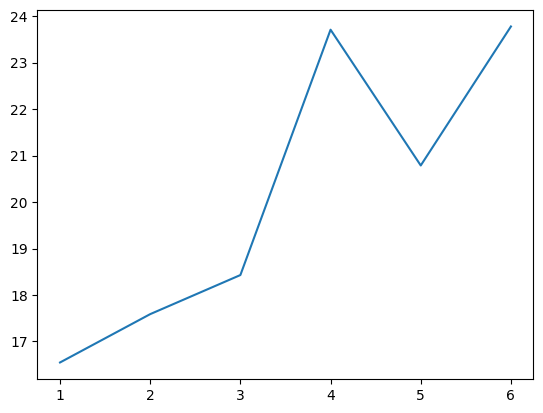

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [38]:
model = keras.models.load_model('LSTM2_character.keras')

### Generación de secuencias

In [41]:
input_text='There was no doubt'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'There was no doubthe has and the mare and the ma'

In [42]:
input_text="I could not get anything"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'I could not get anything and he ware and the mare and '

In [43]:
input_text="So the Nightingale flew"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'So the Nightingale flewere and he ware and the mare a'

In [44]:
input_text="The Happy Prince"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'The Happy Prince and he ware and the mare and '

### Beam search y muestreo aleatorio

In [47]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="the happy prince")

In [48]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!the happy prince, and the ther ander'

In [49]:
salidas = beam_search(model,num_beams=10,num_words=20,input="i know it is very generous of me")

In [50]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!i know it is very generous of mereand the ther ander'

In [51]:
salidas = beam_search(model,num_beams=10,num_words=20,input="many people would")

In [52]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!many people would, and the ther ander'

In [53]:
salidas = beam_search(model,num_beams=10,num_words=20,input="the storm grew")

In [54]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!the storm grewand the ther and the'

### MODELO GRU con lr=0.001

In [57]:
model_gru2 = Sequential()

model_gru2.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru2.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_gru2.add(Dense(vocab_size, activation='softmax'))
model_gru2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_gru2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, None, 39)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 200)      │       144,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 39)       │         7,839 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,439 (595.46 KB)

 Trainable params: 152,439 (595.46 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
history_ppl = []
hist = model_gru2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "GRU2_character.keras")], batch_size=256)

Epoch 1/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 124.3056
 mean perplexity: 13.726845092974996 

Saved new model!
298/298 ━━━━━━━━━━━━━━━━━━━━ 97s 294ms/step - loss: 124.2935
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 2812347392.0000
 mean perplexity: 13.291679940732877 

Saved new model!
298/298 ━━━━━━━━━━━━━━━━━━━━ 81s 272ms/step - loss: 2805757696.0000
Epoch 3/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 2.2413
 mean perplexity: 14.440426015710248 

298/298 ━━━━━━━━━━━━━━━━━━━━ 80s 268ms/step - loss: 2.2412
Epoch 4/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 2.1220
 mean perplexity: 17.30842158676627 

298/298 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - loss: 2.1219
Epoch 5/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 3017509632.0000
 mean perplexity: 22.406821767780105 

298/298 ━━━━━━━━━━━━━━━━━━━━ 84s 281ms/step - loss: 3061393408.0000
Epoch 6/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 1.8267
 mean perplexity: 27.20

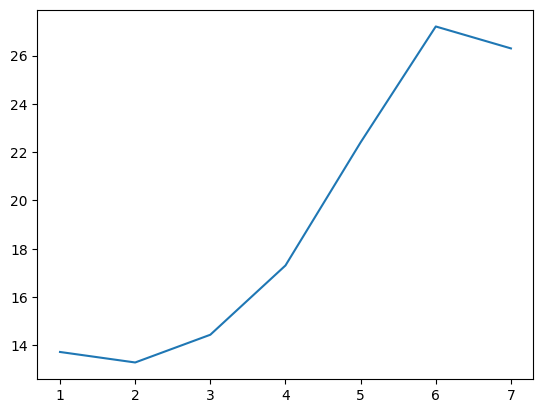

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [70]:
model = keras.models.load_model('GRU2_character.keras')

### Generación de secuencias

In [71]:
input_text='There was no doubt'
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'There was no doubt and the the the the the the t'

In [72]:
input_text="I could not get anything"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'I could not get anything and the the the the the the t'

In [73]:
input_text="So the Nightingale flew"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'So the Nightingale flew and the the the the the the t'

In [74]:
input_text="The Happy Prince"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'The Happy Prince the the the the the the the t'

### Beam search y muestreo aleatorio

In [75]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="the happy prince")

In [76]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!the happy prince the the the the the'

In [77]:
salidas = beam_search(model,num_beams=10,num_words=20,input="i know it is very generous of me")

In [78]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!i know it is very generous of me the the the the the'

In [79]:
salidas = beam_search(model,num_beams=10,num_words=20,input="many people would")

In [80]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!many people would the the the the the'

In [81]:
salidas = beam_search(model,num_beams=10,num_words=20,input="the storm grew")

In [82]:
decode(salidas[0])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!the storm grewand the the the the '

Se observa que SimpleRNN presenta los mejores resultados. Esto se debe a que no maneja secuencias muy largas. También se observa que en los modelos LSTM y GRU fue necesario disminuir la tasa de aprendizaje para que la perplejidad bajara y se pudiera entrenar por más tiempo. Sin embargo, al ser secuencias poco complejas, el modelo SimpleRNN da mejores resultados con una tasa de aprendizaje no tan baja como en los otros casos.